In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Chicago set

CSV file available from https://catalog.data.gov/dataset/crimes-one-year-prior-to-present-e171f

In [2]:
import open_cp.sources.chicago as chicago

points = chicago.default_burglary_data()

In [3]:
len(points.timestamps), points.time_range()

(59184,
 (numpy.datetime64('2016-02-29T06:25:00.000'),
  numpy.datetime64('2017-02-27T23:15:00.000')))

In [4]:
bbox = points.bounding_box()
print("X coord range:", bbox.xmin, bbox.xmax)
print("Y coord range:", bbox.ymin, bbox.ymax)
print(bbox.aspect_ratio)

X coord range: 334018.117311 367319.649846
Y coord range: 552879.750308 594819.314566
1.25938841447


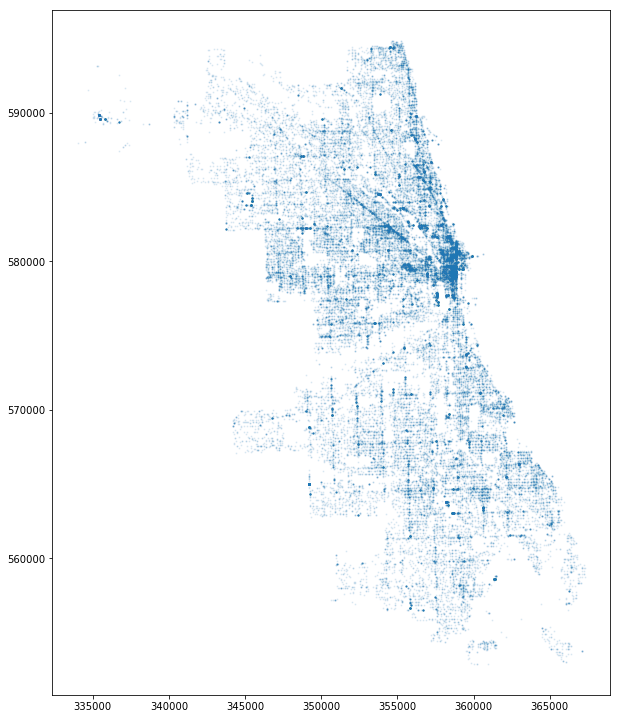

In [5]:
_, ax = plt.subplots(figsize=(10,10 * bbox.aspect_ratio))
ax.scatter(points.coords[0], points.coords[1], alpha=0.1, marker="o", s=1)

As an American city, most streets run North-South or East-West.  Further, the data is geocoded to the centre of the "block", to anonymise the data.  (Though this is slightly inconsistent, if one looks closely at the raw CSV file.)

In the plot above:

   - the clump at the upper left is the airport.
   - We see a large clump of theft data downtown.
   - It would be interesting to know what causes the visible lines running north north west from downtown.

In [6]:
mask = ( (points.xcoords >= 355000) & (points.xcoords <= 365000) &
        (points.ycoords >= 575000) & (points.ycoords <= 585000) )

downtown = points[mask]

bbox = downtown.bounding_box()
print("X coord range:", bbox.xmin, bbox.xmax)
print("Y coord range:", bbox.ymin, bbox.ymax)

X coord range: 355000.54864 360647.882859
Y coord range: 575007.0104 584997.43968


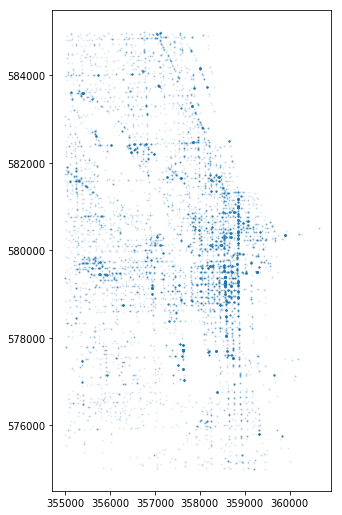

In [7]:
_, ax = plt.subplots(figsize=(5, 5 * bbox.aspect_ratio))
ax.scatter(downtown.coords[0], downtown.coords[1], alpha=0.1, marker="o", s=1)

# UK Crime data

We use an example of January 2017 from West Yorkshire.

In [107]:
import open_cp.sources.ukpolice as ukpolice
points = ukpolice.default_burglary_data()
len(points.timestamps)

2358

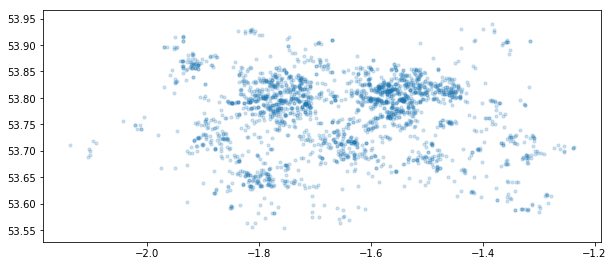

In [9]:
bbox = points.bounding_box()

fig, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(points.xcoords, points.ycoords, s=10, alpha=0.2)

These are longitude / latitude points, which distort distance.  Assuming you have `pyproj` installed, you can project.  For the UK, we use [British National Grid](http://www.spatialreference.org/ref/epsg/osgb36-british-national-grid-odn-height/)

In [10]:
import open_cp

In [11]:
projected_points = open_cp.data.points_from_lon_lat(points, epsg=7405)

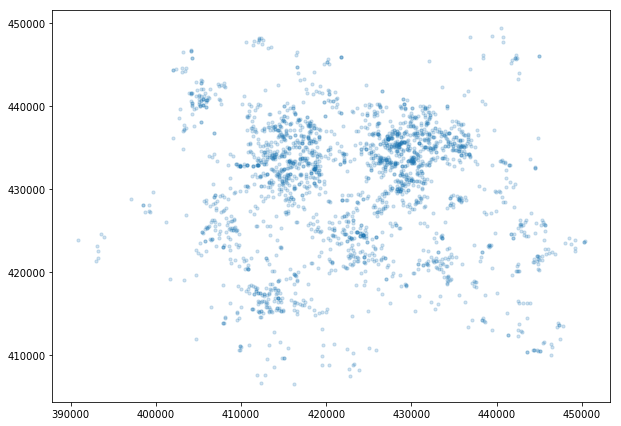

In [12]:
bbox = projected_points.bounding_box()

fig, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(projected_points.xcoords, projected_points.ycoords, s=10, alpha=0.2)

# Random data

In [27]:
import open_cp.sources.random as random
import datetime

In [34]:
region = open_cp.RectangularRegion(390000, 450000, 410000, 450000)
points = random.random_uniform(region, datetime.date(2017,1,1), datetime.date(2017,3,1), 1000)

points.time_range()

(numpy.datetime64('2017-01-01T00:19:00.000'),
 numpy.datetime64('2017-02-28T23:56:59.000'))

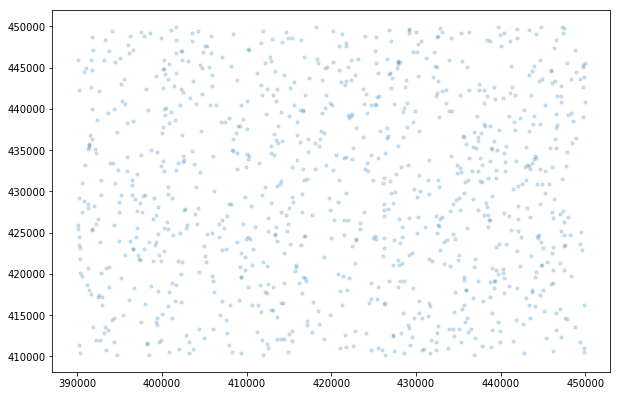

In [35]:
bbox = points.bounding_box()

fig, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(*points.coords, s=10, alpha=0.2)

If we have scipy installed, we can quickly use a 2D Gaussian kernel density estimation to get an estimate of the "risk intensity" from the real West Yorkshire data.

In [100]:
import scipy.stats

In [101]:
kernel = scipy.stats.gaussian_kde(projected_points.coords)

In [102]:
X, Y = np.mgrid[bbox.xmin:bbox.xmax:100j, bbox.ymin:bbox.ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
np.max(Z)

3.2142272355400982e-09

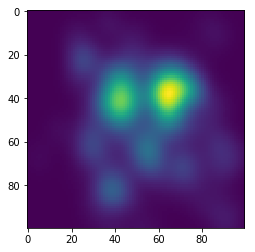

In [103]:
plt.imshow(np.rot90(Z))

Our notion of a `kernel` requires normalised input coordinates in the unit square.  So we need to scale the data.

In [104]:
def scaled_kernel(pts):
    npts = np.empty_like(pts)
    npts[0] = pts[0] * (bbox.xmax - bbox.xmin) + bbox.xmin
    npts[1] = pts[1] * (bbox.ymax - bbox.ymin) + bbox.ymin
    return kernel(npts)

scaled_kernel(np.array([0.5,0.5]))

array([  1.13655408e-09])

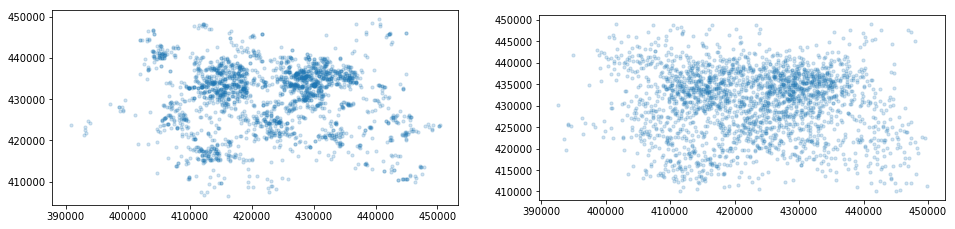

In [119]:
sampler = random.KernelSampler(region, scaled_kernel, 4e-9)
points = random.random_spatial(sampler, datetime.date(2017,1,1), datetime.date(2017,3,1), 2350)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].scatter(*projected_points.coords, s=10, alpha=0.2)
ax[0].set_aspect(bbox.aspect_ratio)
ax[1].scatter(*points.coords, s=10, alpha=0.2)
ax[1].set_aspect(bbox.aspect_ratio)

The real plot still looks somewhat different to the random test data, suggesting that a simple fixed bandwidth Gaussian KDE is not appropriate (which we already knew...)